<a href="https://colab.research.google.com/github/PhataPoster/CNN/blob/main/210110.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install required packages (some are pre-installed on Colab, but this is safe)
!pip install torch torchvision tensorflow tensorflow-datasets pandas matplotlib seaborn scikit-learn -q

In [2]:
# Step 2: Clone your GitHub repository and set directories
!git clone https://github.com/PhataPoster/CNN

import os

# Paths inside the Colab runtime
repo_dir = '/content/CNN'
custom_data_dir = os.path.join(repo_dir, 'dataset')
model_dir = os.path.join(repo_dir, 'model')
os.makedirs(model_dir, exist_ok=True)  # Ensure the model directory exists
print("Repo directory:", repo_dir)
print("Custom images directory:", custom_data_dir)
print("Model directory:", model_dir)

fatal: destination path 'CNN' already exists and is not an empty directory.
Repo directory: /content/CNN
Custom images directory: /content/CNN/dataset
Model directory: /content/CNN/model


In [3]:
# Step 3: Import libraries and set device

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [4]:
# Step 4: Load Rock Paper Scissors dataset from TensorFlow Datasets

print("Loading Rock Paper Scissors dataset...")
train_ds_tf, test_ds_tf = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    batch_size=-1  # full split as one batch
)

# Convert to NumPy arrays (images: uint8, labels: int64)
X_train_np, y_train_np = tfds.as_numpy(train_ds_tf)
X_test_np, y_test_np = tfds.as_numpy(test_ds_tf)

print("Train images shape:", X_train_np.shape)
print("Test images shape:", X_test_np.shape)

Loading Rock Paper Scissors dataset...
Train images shape: (2520, 300, 300, 3)
Test images shape: (372, 300, 300, 3)


In [5]:
# Step 5: Define transforms and DataLoaders

# Image size used for training
IMAGE_SIZE = (150, 150)

# Transform for standard dataset (numpy -> PIL -> Tensor -> Normalize)
train_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

def create_dataloader(images_np, labels_np, batch_size=32, shuffle=False):
    """Converts numpy arrays to a PyTorch DataLoader with the above transform."""
    # Apply transforms to all images
    images_tensor = torch.stack([train_test_transform(img) for img in images_np])
    labels_tensor = torch.from_numpy(labels_np).long()
    dataset = TensorDataset(images_tensor, labels_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

batch_size = 32
train_loader = create_dataloader(X_train_np, y_train_np, batch_size=batch_size, shuffle=True)
test_loader = create_dataloader(X_test_np, y_test_np, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Training batches: 79, Test batches: 12


In [6]:
# Step 6: Define the CNN model

class RPS_CNN(nn.Module):
    """CNN for classifying Rock, Paper, Scissors images."""
    def __init__(self, num_classes=3):
        super(RPS_CNN, self).__init__()
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv Layer 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 1

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Conv Layer 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 2

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Conv Layer 3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 3
        )
        # Calculate final feature map size: 150x150 -> 75x75 -> 37x37 -> 18x18 (integer division)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 18 * 18, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Initialize the model
model = RPS_CNN(num_classes=3).to(device)
print(model)

RPS_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=41472, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [7]:
# Step 7: Define training and evaluation functions

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [8]:
# Step 8: Train or load the model

num_epochs = 10
model_path = os.path.join(model_dir, '210110.pth')

train_losses, val_losses = [], []
train_accs, val_accs = [], []

if os.path.exists(model_path):
    print(f"Found saved model at {model_path}. Loading weights...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    # history arrays will remain empty; you can skip training plot if you want
else:
    print("No saved model found. Training from scratch...")
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)  # using test_loader as validation

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save trained model
    torch.save(model.state_dict(), model_path)
    print(f"Trained model saved to {model_path}")

# Pack history tuple (even if empty when loading)
history = (train_losses, val_losses, train_accs, val_accs)

Found saved model at /content/CNN/model/210110.pth. Loading weights...


In [9]:
# Step 9: Plot training history

def plot_training_history(history):
    """Plots loss and accuracy curves."""
    train_losses, val_losses, train_accs, val_accs = history

    if len(train_losses) == 0:
        print("No training history to plot (model was loaded from saved weights).")
        return

    epochs_range = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax1.plot(epochs_range, train_losses, label='Training Loss')
    ax1.plot(epochs_range, val_losses, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(epochs_range, train_accs, label='Training Accuracy')
    ax2.plot(epochs_range, val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

No training history to plot (model was loaded from saved weights).


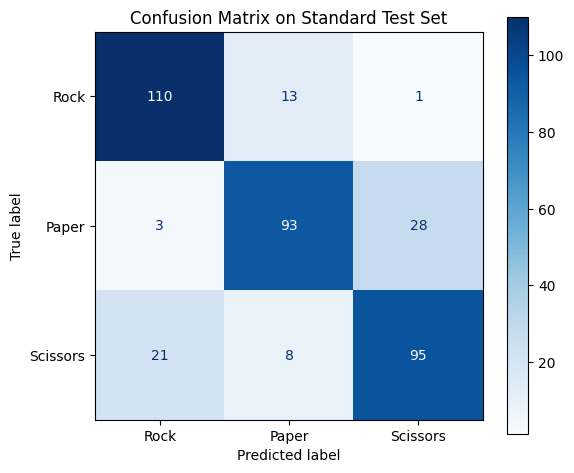

In [10]:
# Step 10: Confusion matrix

class_names = ['Rock', 'Paper', 'Scissors']  # label 0,1,2 in TFDS

def plot_confusion_matrix_func(model, test_loader, class_names):
    """Generates and displays a confusion matrix."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title('Confusion Matrix on Standard Test Set')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_func(model, test_loader, class_names)

Found custom images:
 - /content/CNN/dataset/6219894621173648141_120.jpg
 - /content/CNN/dataset/6219894621173648145_120.jpg
 - /content/CNN/dataset/6219894621173648137_120.jpg
 - /content/CNN/dataset/6219894621173648143_120.jpg
 - /content/CNN/dataset/6219894621173648146_120.jpg
 - /content/CNN/dataset/6219894621173648142_120.jpg
 - /content/CNN/dataset/6219894621173648139_120.jpg
 - /content/CNN/dataset/6219894621173648140_120.jpg
 - /content/CNN/dataset/6219894621173648144_120.jpg
 - /content/CNN/dataset/6219894621173648138_120.jpg


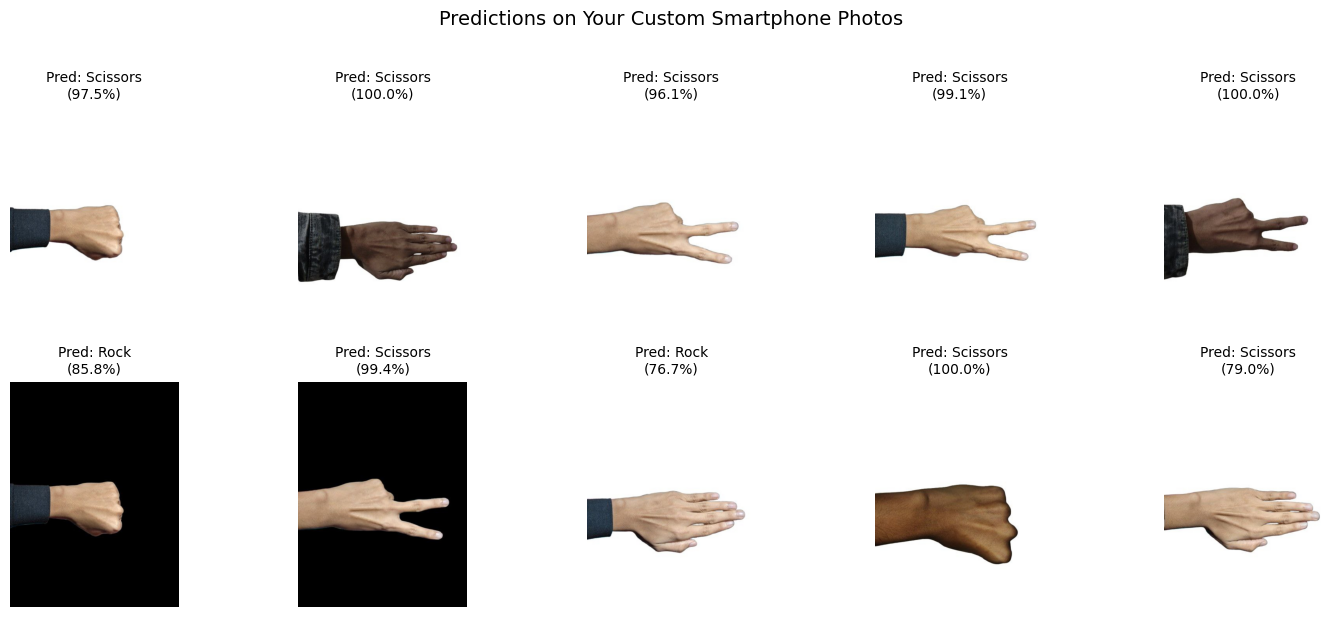

In [11]:
# Step 11: Real-world predictions on custom images

def process_custom_image(image_path):
    """Loads and preprocesses a single custom image (RGB)."""
    img = Image.open(image_path).convert('RGB')
    transform_custom = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    return transform_custom(img).unsqueeze(0)  # Add batch dimension

# Get paths to your custom images
custom_image_paths = [os.path.join(custom_data_dir, f)
                      for f in os.listdir(custom_data_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print("Found custom images:")
for p in custom_image_paths:
    print(" -", p)

model.eval()
predictions = []
with torch.no_grad():
    for img_path in custom_image_paths:
        tensor = process_custom_image(img_path).to(device)
        output = model(tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)
        predictions.append({
            'path': img_path,
            'predicted': class_names[predicted_idx.item()],
            'confidence': confidence.item() * 100
        })

def display_prediction_gallery(predictions, cols=5):
    """Displays a grid of custom images with predictions."""
    num_images = len(predictions)
    if num_images == 0:
        print("No custom images found in dataset/ folder.")
        return

    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    if rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, pred in enumerate(predictions):
        img = Image.open(pred['path'])
        axes[idx].imshow(img)
        title = f"Pred: {pred['predicted']}\n({pred['confidence']:.1f}%)"
        axes[idx].set_title(title, fontsize=10)
        axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')

    plt.suptitle('Predictions on Your Custom Smartphone Photos', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

display_prediction_gallery(predictions)

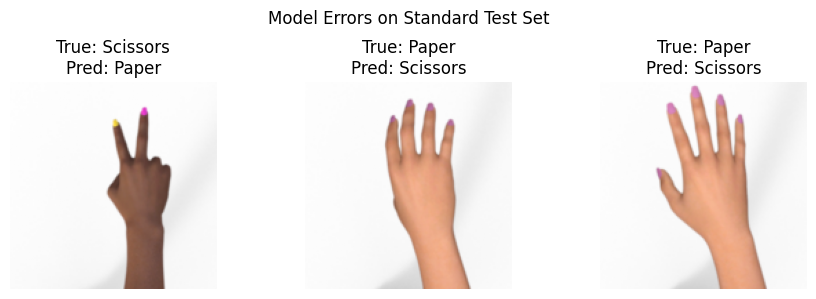

In [12]:
# Step 12: Visual error analysis

def display_errors(model, test_loader, class_names, num_errors=3):
    """Displays misclassified images from the standard test set."""
    model.eval()
    error_images, error_true, error_pred = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            incorrect_mask = (preds != labels)
            incorrect_images = images[incorrect_mask].cpu()
            incorrect_true = labels[incorrect_mask].cpu()
            incorrect_pred = preds[incorrect_mask].cpu()

            error_images.extend(incorrect_images)
            error_true.extend(incorrect_true)
            error_pred.extend(incorrect_pred)

            if len(error_images) >= num_errors:
                break

    if len(error_images) == 0:
        print("No misclassified images found (or model not trained properly).")
        return

    fig, axes = plt.subplots(1, num_errors, figsize=(num_errors*3, 3))
    if num_errors == 1:
        axes = [axes]

    for i in range(min(num_errors, len(error_images))):
        img = error_images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(np.clip(img, 0, 1))
        true_name = class_names[error_true[i]]
        pred_name = class_names[error_pred[i]]
        axes[i].set_title(f"True: {true_name}\nPred: {pred_name}")
        axes[i].axis('off')

    plt.suptitle('Model Errors on Standard Test Set', fontsize=12)
    plt.tight_layout()
    plt.show()

display_errors(model, test_loader, class_names, num_errors=3)